## Advanced Lane Finding
[![Udacity - Self-Driving Car NanoDegree](https://s3.amazonaws.com/udacity-sdc/github/shield-carnd.svg)](http://www.udacity.com/drive)


In this project, your goal is to write a software pipeline to identify the lane boundaries in a video, but the main output or product we want you to create is a detailed writeup of the project.  Check out the [writeup template](https://github.com/udacity/CarND-Advanced-Lane-Lines/blob/master/writeup_template.md) for this project and use it as a starting point for creating your own writeup.  

Creating a great writeup:
---
A great writeup should include the rubric points as well as your description of how you addressed each point.  You should include a detailed description of the code used in each step (with line-number references and code snippets where necessary), and links to other supporting documents or external references.  You should include images in your writeup to demonstrate how your code works with examples.  

All that said, please be concise!  We're not looking for you to write a book here, just a brief description of how you passed each rubric point, and references to the relevant code :). 

You're not required to use markdown for your writeup.  If you use another method please just submit a pdf of your writeup.

The Project
---

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

The images for camera calibration are stored in the folder called `camera_cal`.  The images in `test_images` are for testing your pipeline on single frames.  If you want to extract more test images from the videos, you can simply use an image writing method like `cv2.imwrite()`, i.e., you can read the video in frame by frame as usual, and for frames you want to save for later you can write to an image file.  

To help the reviewer examine your work, please save examples of the output from each stage of your pipeline in the folder called `output_images`, and include a description in your writeup for the project of what each image shows.    The video called `project_video.mp4` is the video your pipeline should work well on.  

The `challenge_video.mp4` video is an extra (and optional) challenge for you if you want to test your pipeline under somewhat trickier conditions.  The `harder_challenge.mp4` video is another optional challenge and is brutal!

If you're feeling ambitious (again, totally optional though), don't stop there!  We encourage you to go out and take video of your own, calibrate your camera and show us how you would implement this project from scratch!

Rubric: https://review.udacity.com/#!/rubrics/571/view

## How to write a README
A well written README file can enhance your project and portfolio.  Develop your abilities to create professional README files by completing [this free course](https://www.udacity.com/course/writing-readmes--ud777).




### Calibration

#### 1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images

In [136]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
%matplotlib inline

In [111]:
def calc_calibration_points(images, n_x, n_y):
    '''
    This function takes a series of chessboard images taken with the camera for which the calibration points are
    to be calculated. The number of chessboard corners in x and y direction must be counted manually and passed
    to the function as well. "Chessboard corners" are only points where two black and two white squares 
    intersect.
    The function returns all recognized chessboard corners in the following way:
    object_points: a list of 3D points corresponding to the location of the corners in real world coordinates
    image_points: a list of 2D points corresponding to the location of the corners in image space
    '''
    # Prepare object points, like (0,0,0), (1,0,0), (2,0,0), ...
    object_points_current = np.zeros((n_x*n_y, 3), np.float32)
    object_points_current[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

    # Arrays to store object points and image points from all the images
    object_points = [] # 3d points (enumeration of the corners) in real world space
    image_points = [] # 2d points in image plane

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        image = cv2.imread(fname)
        image_grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(image_grayscale, (n_x,n_y), None)

        # If found, add object points, image points
        if ret == True:
            object_points.append(object_points_current)
            image_points.append(corners)

            # Draw and display the corners
            cv2.drawChessboardCorners(image, (n_x,n_y), corners, ret)
            write_name = 'camera_cal/corners_found' + str(idx) + '.jpg'
            cv2.imwrite(write_name, image)
            cv2.imshow('Image', image)
            cv2.waitKey(500)

    cv2.destroyAllWindows()
    
    return object_points, image_points

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Counted chessboard corners
n_x = 9
n_y = 6

# Get object_points and image_points for calibration
object_points, image_points = calc_calibration_points(images, n_x, n_y)

# Read in image used for calibration
image = cv2.imread('camera_cal/calibration3.jpg')
image_size = (image.shape[1], image.shape[0])

# Calibrate camera given object_points and image_points
# Function returns reprojection error, camera matrix, distortion coefficients, rotation and translation 
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(object_points, image_points, image_size, None, None)
    
# Save camera calibration result for later use
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump(dist_pickle, open("camera_cal/dist_pickle.p", "wb"))

In [112]:
# Undistort image
image_undistorted = cv2.undistort(image, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(image_undistorted)
ax2.set_title('Undistorted Image', fontsize=30)

Text(0.5,1,'Undistorted Image')

In [113]:
def calc_transform_matrix_chessboard(image_undistorted, n_x, n_y, mtx, dist, offset):
    '''
    This function takes the undistorted color image of a chessboard for which the perspective transform matrix 
    is to be calculated. The number of chessboard corners in x and y direction must be counted manually and 
    passed to the function alongside the camera's distortion coefficients dist and the target offset of the 
    corners from the image edges in topview image. "Chessboard corners" are only points where two black and two 
    white squares intersect.
    The function returns the perspective transform matrix.
    '''
    # Grayscale image
    image_grayscale = cv2.cvtColor(image_undistorted, cv2.COLOR_BGR2GRAY)

    # Find chessboard corners
    # Function returns non-zero value ret if all corners are found
    ret, corners = cv2.findChessboardCorners(image_grayscale, (n_x, n_y), None)
    cv2.drawChessboardCorners(image_undistorted, (n_x,n_y), corners, ret)

    if ret == True:
        # Define source and destination coordinates
        src = np.float32([corners[0], corners[n_x-1], corners[-1], corners[-n_x]])

        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], [img_size[0]-offset, img_size[1]-offset], [offset, img_size[1]-offset]])

        # Get transform matrix M
        M = cv2.getPerspectiveTransform(src, dst)
        return M
    else:
        print("Not all chessboard corners were found. Try using a different image for obtaining the transform matrix!")

# Offset of corners from image edges in unwarped image
offset = 100

# Calculate transform
M = calc_transform_matrix_chessboard(image_undistorted, n_x, n_y, mtx, dist, offset)
image_topview = cv2.warpPerspective(image_undistorted, M, image_size)

In [114]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(image_topview)
ax2.set_title('Undistorted and Topview Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Pipeline (test images)

#### 1. Apply a distortion correction to raw images

In [115]:
image = mpimg.imread('test_images/test5.jpg')

# Read in the saved camera matrix and distortion coefficients
dist_pickle = pickle.load(open("camera_cal/dist_pickle.p", "rb"))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
image_undistorted = cv2.undistort(image, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(image_undistorted)
ax2.set_title('Undistorted Image', fontsize=30)

Text(0.5,1,'Undistorted Image')

#### 2. Use color transforms, gradients, etc. to create a thresholded binary image

In [123]:
def abs_threshold(image, orient='x', sobel_kernel=3, thresh_min=0, thresh_max=255):
    '''
    This function takes a single channel image (e.g. grayscale), applies the Sobel operator in orient='x' or 
    orient='y' orientation with the the specified kernel, then takes the absolute value, scales the image back to 
    (0,255) and applies the specified threshold.
    '''
    # Convert to grayscale
    sobel = np.copy(image)*0

    # Take the derivative in x or y given orient='x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))

    # Create a binary mask where thresh_min and thresh_max are met
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    return binary_output

def mag_threshold(image, sobel_kernel=3, mag_thresh=(0, 255)):
    '''
    This function applies the Sobel operator in x and y orientation separately with the the specified kernel, then 
    calculates the magnitude using np.sqrt(), scales the image back to (0,255) and applies the specified threshold.
    '''
    # Convert to grayscale
    image_grayscale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Take the gradient in x and y separately
    sobel_x = cv2.Sobel(image_grayscale, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(image_grayscale, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Calculate the magnitude
    sobel_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale_factor = 255 / np.max(sobel_magnitude)
    
    scaled_sobel_magnitude = np.uint8(sobel_magnitude * scale_factor)

    # Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobel_magnitude)
    binary_output[(scaled_sobel_magnitude >= mag_thresh[0]) & (scaled_sobel_magnitude <= mag_thresh[1])] = 1
    
    return binary_output

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    '''
    This function applies the Sobel operator in x and y orientation separately with the the specified kernel, then 
    calculates the direction of the gradient using np.arctan2() and applies the specified threshold.
    '''
    # Convert to grayscale
    image_grayscale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Take the gradient in x and y separately
    sobel_x = cv2.Sobel(image_grayscale, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(image_grayscale, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Take the absolute value of the x and y gradients
    abs_sobel_x = np.absolute(sobel_x)
    abs_sobel_y = np.absolute(sobel_y)
    
    # Calculate the direction of the gradient 
    sobel_direction = np.arctan2(abs_sobel_y, abs_sobel_x)
    
    # Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(sobel_direction)
    binary_output[(sobel_direction >= thresh[0]) & (sobel_direction <= thresh[1])] = 1
    
    return binary_output

# Parameters
ksize = 5
S_thresh=(170, 255)
L_thresh=(20, 255)
sobel_x_L_thresh=(20, 100)

# Convert to HLS color space
image_hls = cv2.cvtColor(image_undistorted, cv2.COLOR_RGB2HLS)

# Get single color channels
image_S = image_hls[:,:,2]
image_L = image_hls[:,:,1]

sobel_x_L_binary = abs_threshold(image_L, orient='x', sobel_kernel=ksize, thresh_min=sobel_x_L_thresh[0], thresh_max=sobel_x_L_thresh[1])

# Threshold color channel
S_binary = np.zeros_like(image_S)
S_binary[(image_S >= S_thresh[0]) & (image_S <= S_thresh[1])] = 1
    
# Threshold L channel
L_binary = np.zeros_like(image_S)
L_binary[(image_L >= L_thresh[0]) & (image_L <= L_thresh[1])] = 1

# Add all binary images into a single binary image
image_binary = np.zeros_like(image_S)
image_binary[(sobel_x_L_binary == 1) | (S_binary == 1) & (L_binary == 1)] = 1

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(image_binary, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### 3a. Apply a perspective transform to rectify color image ("birds-eye view")

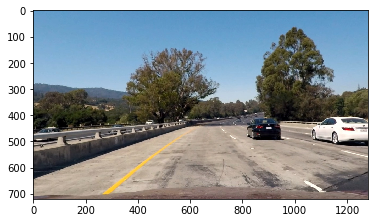

In [241]:
# image = mpimg.imread('test_images/straight_lines1.jpg')
image = mpimg.imread('test_images/test1.jpg')
image_undistorted = cv2.undistort(image, mtx, dist, None, mtx)

image_size = (image_undistorted.shape[1], image_undistorted.shape[0]) # (x_size, y_size)
x_size = image_size[0]
y_size = image_size[1]

plt.imshow(image_undistorted)

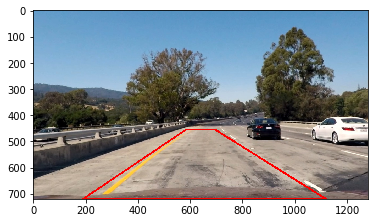

In [242]:
# Corners manually obtained from looking at picture
# bottom_left, bottom_right, top_left, top_right
corners = [(190, y_size), (1120, y_size), (585, 455), (695, 455)]

image_undistorted_lines = np.copy(image_undistorted)

# Draw lines corresponding to source points
cv2.line(image_undistorted_lines, corners[0], corners[1], (255,0,0), 5)
cv2.line(image_undistorted_lines, corners[2], corners[3], (255,0,0), 5)
cv2.line(image_undistorted_lines, corners[0], corners[2], (255,0,0), 5)
cv2.line(image_undistorted_lines, corners[1], corners[3], (255,0,0), 5)

plt.imshow(image_undistorted_lines)

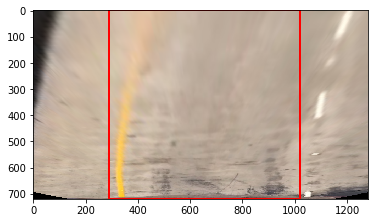

In [243]:
def calc_transform_matrix(image_binary, n_x, n_y, mtx, dist, corners, offset):
    '''
    This function takes the undistorted color image of a chessboard for which the perspective transform matrix 
    is to be calculated. The number of chessboard corners in x and y direction must be counted manually and 
    passed to the function alongside the camera's distortion coefficients dist and the target offset of the 
    corners from the image edges in topview image. "Chessboard corners" are only points where two black and two 
    white squares intersect.
    The function returns the perspective transform matrix.
    '''
    
    # Find chessboard corners
    # Function returns non-zero value ret if all corners are found
    # ret, corners = cv2.findChessboardCorners(image_grayscale, (n_x, n_y), None)
    # cv2.drawChessboardCorners(image_undistorted, (n_x,n_y), corners, ret)
    
    # Define source and destination coordinates
    src = np.float32([corners[0], corners[1], corners[2], corners[3]])

    # bottom_left, bottom_right, top_left, top_right
    dst = np.float32([(corners[0][0]+offset, corners[0][1]), (corners[1][0]-offset, corners[1][1]), (corners[0][0]+offset, 0), (corners[1][0]-offset, 0)])

    # Get transform matrix M
    M = cv2.getPerspectiveTransform(src, dst)
    return M

offset = 100

# Calculate transform
M = calc_transform_matrix(image_undistorted, n_x, n_y, mtx, dist, corners, offset)

# Warp image
image_topview = cv2.warpPerspective(image_undistorted, M, image_size)

# Draw lines corresponding to destination points
cv2.line(image_topview, (corners[0][0]+offset, corners[0][1]), (corners[1][0]-offset, corners[1][1]), (255,0,0), 5)
cv2.line(image_topview, (corners[0][0]+offset, 0), (corners[1][0]-offset, 0), (255,0,0), 5)
cv2.line(image_topview, (corners[0][0]+offset, corners[0][1]), (corners[0][0]+offset, 0), (255,0,0), 5)
cv2.line(image_topview, (corners[1][0]-offset, corners[1][1]), (corners[1][0]-offset, 0), (255,0,0), 5)

plt.imshow(image_topview)

#### 3b. Apply a perspective transform to rectify binary image

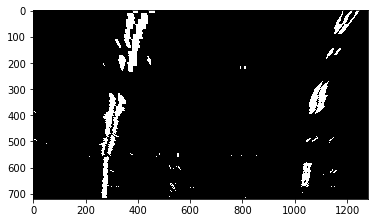

In [245]:
# Warp image
image_binary_topview = cv2.warpPerspective(image_binary, M, image_size)

plt.imshow(image_binary_topview, cmap='gray')

#### 4. Detect lane pixels and fit to find the lane boundary

#### 5. Determine the curvature of the lane and vehicle position with respect to center

#### 6. Warp the detected lane boundaries back onto the original image

#### 7. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position

### Pipeline (video)